In [52]:
from fit_completeness_to_catalog import *
import os
name = "sullivan"
cut_to_Ms = True
nwalkers = 24
ndim = 8
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
catalog, num_stars = get_catalog_and_numstars(name, cut_to_Ms)
num_stars = 200000
if os.path.isfile('synth{}.h5'.format(str(num_stars))):
    synth = pd.read_hdf('synth{}.h5'.format(str(num_stars)))
else:
    print("Making synth solar systems")
    synth = make_synth_solar_systems(num_stars=num_stars)
    synth.to_hdf('synth{}.h5'.format(str(num_stars)), key='synth')
synth = synth[synth.transit_bool]
hist_synth, hist_catalog = make_hists(synth, catalog, plot=False)
print("Injected {} transiting planets".format(int(np.sum(hist_synth))))

Selected 200000 stars
Injected 12399 transiting planets


In [54]:
ll, p0 = make_mcmc_setup(hist_synth, hist_catalog, nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ll)
_ = sampler.run_mcmc(p0, 10000, progress="notebook")
sampler.reset()
pos, _, _ = sampler.run_mcmc(p0, 50000, store=True, progress="notebook")

Found least-squares solution: [ 0.2648838  -0.64357725  0.20831825  0.03993947  0.62694156  2.93996715
 -0.02170565 -0.20523035]
Set initial condition


In [57]:
leastsq = p0[0]
print(ll(leastsq))
print(ll(leastsq + np.random.normal(0, 1e-3, size=ndim)))

20.482060079071232
20.388090145735248


In [61]:
i = 0
for _ in range(29):
    try:
        print(sampler.get_autocorr_time())
        break
    except BaseException:
        newstart = np.median(sampler.chain[:,-10000:,:], axis=1)
        sampler.run_mcmc(newstart, 10000, store=True, progress='notebook')
        print(i)
        i += 1


0



1



2



3



4



5



6



7



8



9



10



11



12



13


KeyboardInterrupt: 

In [62]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 5220;
tau: [20823.45840268  3548.58299593  3311.05994045 21217.14215275
 19889.31728638  4120.124649    4196.86211348 19070.30330757]

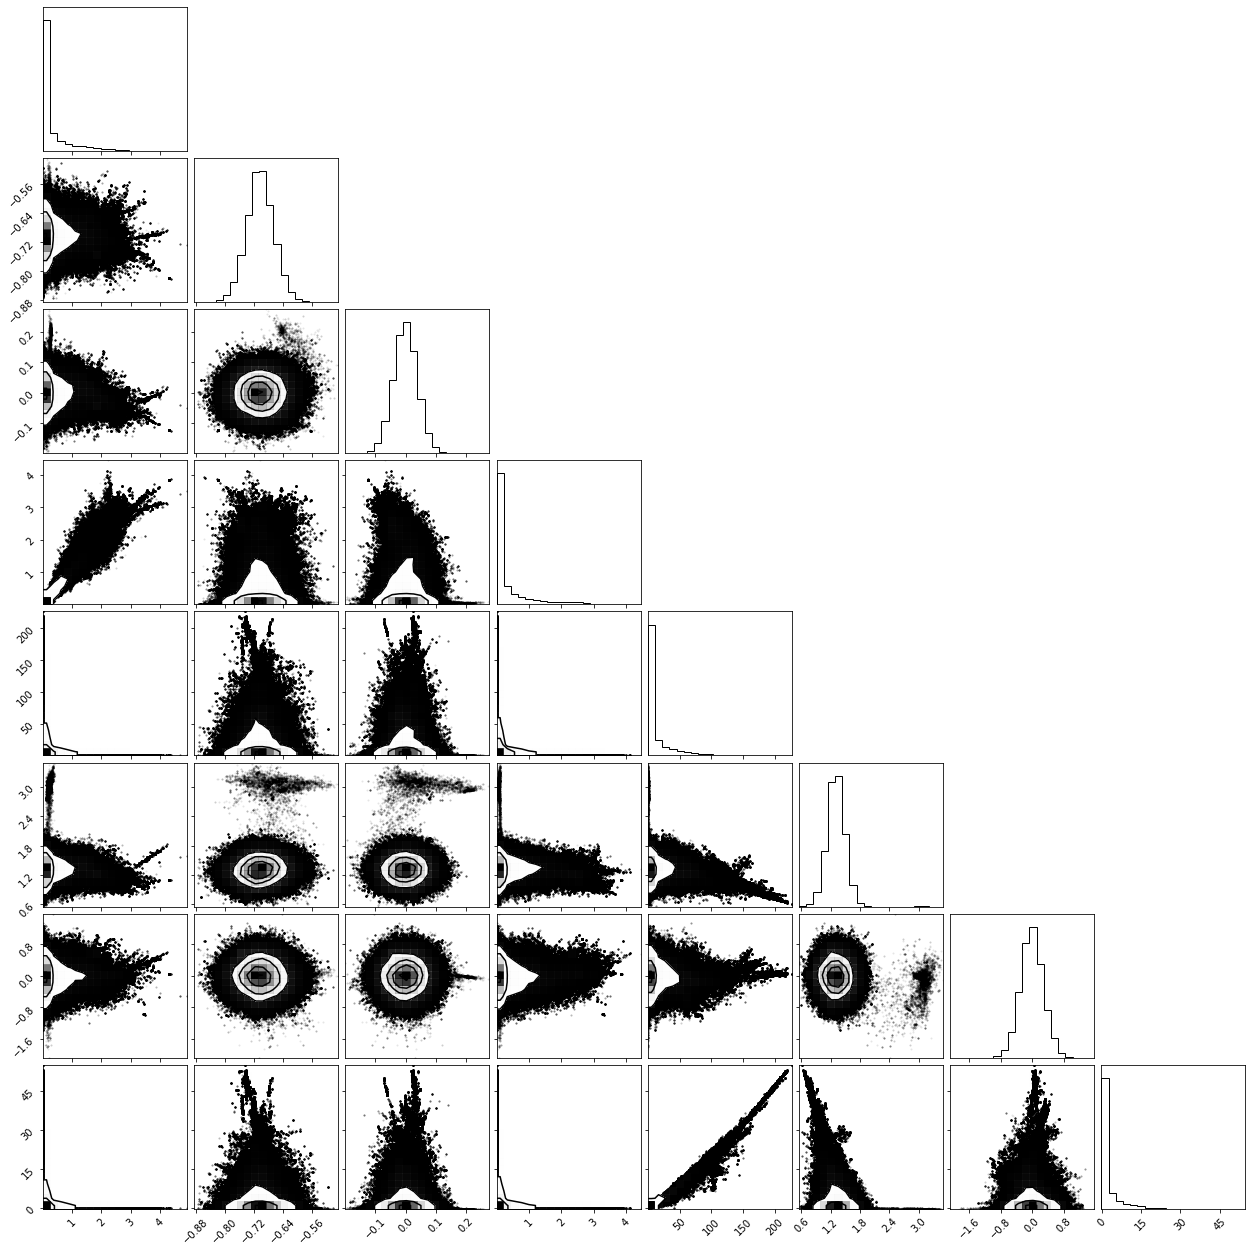

In [63]:
_ = corner.corner(sampler.flatchain) # check autocorrelation times

In [64]:
from IPython.display import display, Math
labels = ['p0', 'p1', 'p2', 'p3', 'r0', 'r1', 'r2', 'r3']

best_params = np.empty(ndim,)
for i in range(ndim):
    mcmc = np.percentile(sampler.get_chain(discard=100, thin=15, flat=True)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    best_params[i] = mcmc[1]
    display(Math(txt))
# cut off days at 27, or at 90th percentile for TOIs||

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [71]:
comp_p = comp_poly(np.log(bins_p), *best_params[:4])
comp_r = comp_poly(np.log(bins_r), *best_params[4:])
comp_p -= np.min(comp_p)
comp_p /= np.max(comp_p)
comp_r -= np.min(comp_r)
comp_r /= np.max(comp_r)

In [78]:
comp_p

array([0.        , 0.07732874, 0.11900062, 0.13604022, 0.13947213,
       0.14032092, 0.14961118, 0.17836748, 0.23761441, 0.33837654,
       0.49167846, 0.70854476, 1.        ])

In [79]:
comp_r

array([0.00000000e+00, 8.17032106e-04, 3.70699439e-03, 9.98805804e-03,
       2.09783942e-02, 3.79961742e-02, 6.23595691e-02, 9.53867501e-02,
       1.38395888e-01, 1.92705155e-01, 2.59632722e-01, 3.40496759e-01,
       4.36615438e-01, 5.49306931e-01, 6.79889408e-01, 8.29681041e-01,
       1.00000000e+00])

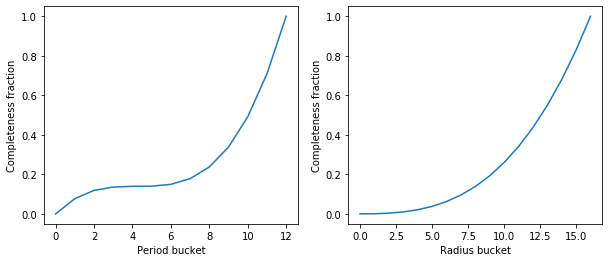

In [82]:
plot_marginalized_comps(comp_p, comp_r)

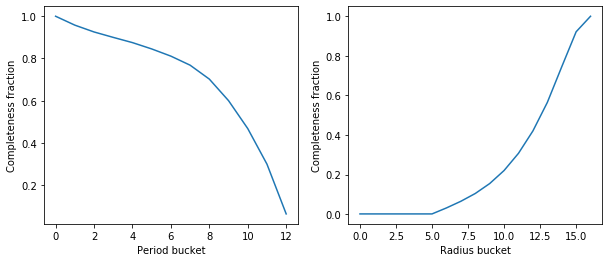

In [69]:
comp04m = np.load('ballard_data/Completeness_0.4Msun.npy')
num_iters = 100
rcomp_marginalized = np.mean(comp04m[-1].dot(np.random.uniform(size=(13,num_iters))), axis=1)
rcomp_marginalized /= rcomp_marginalized[-1]
pcomp_marginalized = np.mean(comp04m[-1].T.dot(np.random.uniform(size=(17,num_iters))), axis=1)
pcomp_marginalized /= pcomp_marginalized[0]
plot_marginalized_comps(pcomp_marginalized, rcomp_marginalized)

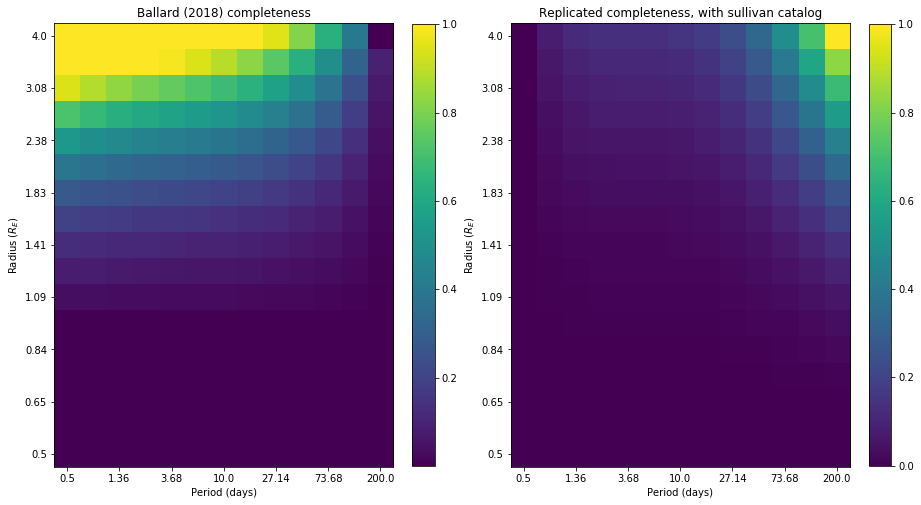

In [83]:
repcomp = np.outer(comp_p, comp_r).T
plot_overall_comps(repcomp, name)